# Tests for significance of difference between 0TEK0503244655 scores and all others

In [29]:
from pathlib import Path
import json

import arviz as az
import pymc as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'seaborn'

## Test to see if any tiles are outliers

Only using accuracy.  We will use a truncated normal distribution with mu at 0.95.

In [78]:
score_path = Path.cwd() / 'tile_scores.csv'
img_dir = Path('/home/michael/thesis/images')

df = pd.read_csv(score_path)
df

,Unnamed: 0,tile,year,ROC AUC,Accuracy,Log Loss
0,0,10TEL0509245547,2022,0.9714,0.9315,0.3583
1,1,10TDL0458245240,2022,0.9953,0.9836,0.1878
2,2,10TEK0503244655,2022,0.9156,0.8444,0.7774
3,3,10TDL0464245187,2022,0.9959,0.9858,0.0598
4,4,10TDL0480045075,2020,0.9833,0.9976,0.0499
5,5,10TDL0480045075,2022,0.9977,0.9820,0.1009
6,6,10TDL0480045075,2018,NaN,0.9451,NaN
7,7,10TEK0500244992,2022,0.9996,0.9887,0.0503
8,8,10TDL0488245360,2022,0.9990,0.9859,0.1460


In [3]:
cols = df.columns.to_list()[-3:]


['ROC AUC', 'Accuracy', 'Log Loss']

In [4]:
obs_path = Path.cwd() / 'obs.csv'

obs = pd.read_csv(obs_path)
obs = obs [['roc', 'acc', 'loss']]
obs.columns = cols
obs.head()


,ROC AUC,Accuracy,Log Loss
0,0.999959,0.998047,0.019129
1,0.999271,0.998047,0.021949
2,1.000000,1.000000,0.008913
3,1.000000,0.998047,0.011567
4,0.999918,0.996094,0.018860


Using Accuracy

In [7]:
def post_likelihoods(observations, score):
    '''returns posterior predictive likelihood for each tile prediction 
    being from the underlying model of the other tiles.'''
    
    # get relevant obs
    obs = observations[score].values

    # Bayesian model
    with pm.Model() as model:
        
        # weakly informative priors
        mu = pm.TruncatedNormal(
            'mu',
            mu=0.9, 
            sigma=0.1, 
            lower=0, 
            upper=1)
        
        sigma = pm.Normal(
            'sigma',
            mu=0.3,
            sigma=0.05
        )
        
        # normal likelihood, with bounds
        observed = pm.TruncatedNormal(
            'observed',
            mu=mu,
            sigma=sigma,
            lower=0,
            upper=1,
            observed=obs
            )
        
        # posterior
        trace = pm.sample(500, tune=2000, cores=16)

    # prior and posterior predictive distribution
    with model:
        prior_predictive = pm.sample_prior_predictive(samples=50)
        posterior_predictive = pm.sample_posterior_predictive(trace)

    return prior_predictive, posterior_predictive, trace


In [81]:
score = 'Accuracy'

# get predictive distributions
prior_predictive, posterior_predictive, trace = post_likelihoods(obs, score)
#draw samples
draws = posterior_predictive['posterior_predictive'].observed.to_numpy().flatten()

# get 95% credible interval
hdi95 = az.hdi(draws, 0.95)
lower = hdi95[0]
upper = hdi95[1]

Only 200 samples in chain.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


KeyboardInterrupt: 

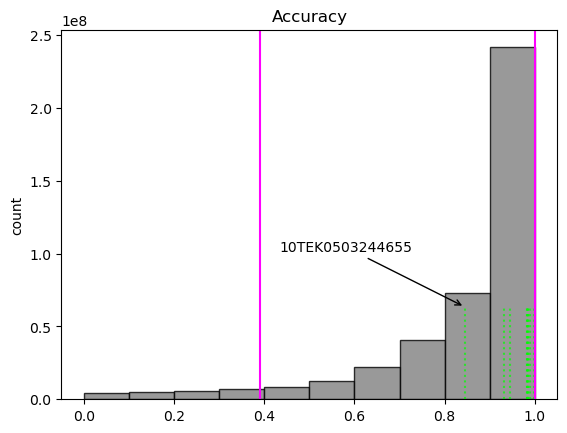

In [79]:
fig, ax = plt.subplots(1, 1)
ax.hist(
    draws,
    edgecolor='k',
    facecolor='grey',
    alpha=0.8);

for i, row in df.iterrows():
    ax.axvline(
        row.Accuracy,
        c='lime',
        alpha=0.7,
        ymax = 0.25,
        linestyle = ":");

x = df[df.tile == '10TEK0503244655'].Accuracy.values[0]

ax.annotate('10TEK0503244655',
            xy=(x, 0.25),
            xycoords=('data', 'axes fraction'),
            xytext=(0.44, 0.4),
            textcoords='axes fraction',
            arrowprops=dict(arrowstyle="->",)
            );

ax.set_title('Accuracy');
ax.grid(visible=False)
ax.set_ylabel('count');
ax.axvline(x=lower, c='magenta');
ax.axvline(x=upper, c='magenta');

plt.savefig(img_dir / 'accuracy_hdi.png')


In [80]:
az.plot_trace(trace.posterior)

NameError: name 'trace' is not defined